# Getting the speed matrix

In [1]:
%matplotlib inline  
from pymongo import MongoClient
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import math

import pandas as pd
import importlib

#from sklearn.cluster import KMeans
#from sklearn.cluster import AffinityPropagation

#Ploting
import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import MarkerCluster

In [2]:
client = MongoClient()
congestion = client.congestion
data = congestion.coyote2

osm_rennes = client.osm
roads = osm_rennes.roads

#### Some functions

In [3]:
def print_road(road_id):

    coords = roads.find({'_id': road_id})[0]['loc']['coordinates']

    folium_map = folium.Map(location=[48.11,-1.66],
                         zoom_start=13,
                         tiles="OpenStreetMap")
    folium.PolyLine(
        locations=[[x[1], x[0]] for x in coords],
        color='red'
    ).add_to(folium_map)

    return folium_map

def NaN_percent(df):
    return df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100

def percents(df):
    return (df.isnull().sum(axis=1).sort_values(ascending=True) / df.shape[1] * 100).describe()

## First get the list of directions for the roads

*We want for each road one or two directions corresponding to the one or two circulation directions*

### Getting the headings with clustering

Get all the roads with an array of the headings

In [3]:
roads_with_headings = list(data.aggregate([
       {
        "$group" : {
          "_id" : {
              "matchingRoad": "$matching_road"
           },
          "headings": { "$push": "$heading"},
          "count": { "$sum": 1 } 
        }
       },
       {"$sort": {"count": -1}}
    ]))

In [9]:
pprint(roads_with_headings[5000])

{'_id': {'matchingRoad': 49277241},
 'count': 6,
 'headings': [180, 182, 178, 184, 169, 178]}


We then do clustering to find the one or two main headings

In [29]:
headings = np.array(roads_with_headings[5000]['headings'])
headings = headings.reshape(-1,1)

In [69]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(headings)
print(kmeans.cluster_centers_)
print(kmeans.labels_)
print(kmeans.inertia_)

[[169. ]
 [180.4]]
[1 1 1 1 0 1]
27.200000000000003


In [45]:
kmeans1 = KMeans(n_clusters=1, random_state=0).fit(headings)
print(kmeans1.cluster_centers_)
print(kmeans1.labels_)
print(kmeans1.inertia_)

[[178.5]]
[0 0 0 0 0 0]
135.5


In [5]:
def two_clusters(centers, verbose=False):
    dist = np.abs(centers[0] - centers[1])
    if dist < 100:
        if verbose:
            print("Distance < 100deg ({:.1f}): only one cluster".format(dist[0]))
        return False
    return True    

In [88]:
two_clusters(kmeans.cluster_centers_,True)

Distance < 100deg (11.4): only one cluster


False

In [89]:
def get_centers(headings):
    headings = headings.reshape(-1,1)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(headings)
    centers=kmeans.cluster_centers_
    if not two_clusters(centers):
        kmeans = KMeans(n_clusters=1, random_state=0).fit(headings)
        centers=kmeans.cluster_centers_
    return centers

In [105]:
headings = np.array([k for k in roads_with_headings[100]['headings'] if k!= 0])
get_centers(headings)

array([[166.29176471],
       [315.92307692]])

(array([  1.,  22.,  72., 313.,   8.,   5.,   2.,   1.,   0.,   1.,   0.,
          0.,   0.,   5.,   0.,   0.,   0.,   1.,   2.,   5.]),
 array([133.  , 143.85, 154.7 , 165.55, 176.4 , 187.25, 198.1 , 208.95,
        219.8 , 230.65, 241.5 , 252.35, 263.2 , 274.05, 284.9 , 295.75,
        306.6 , 317.45, 328.3 , 339.15, 350.  ]),
 <a list of 20 Patch objects>)

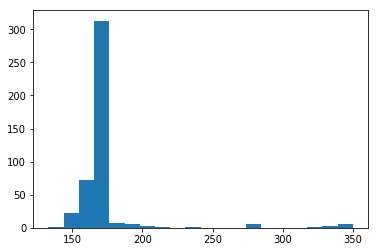

In [104]:
plt.hist([k for k in roads_with_headings[100]['headings'] if k!= 0], bins=20)

In [4]:
print_road(390332978)

### Clustering didn't work...

<font color="red">Two problems:  
- Zeros....    
- How to "weight" the clusters  
</font>

Ideas:   
- Maybe try using the line to get the headings instead of clustering
- We already know one/two with the tags 

### Using the coordinates

In [6]:
def get_north_azimut(coords):
    """
    Get the north azimut of a road by using its geometry.   
    @params   
    coords: The array of coordinates from the osm data.
    """
    degs = math.degrees(math.atan2((coords[-1][0] - coords[0][0]),(coords[-1][1] - coords[0][1])))
    if degs < 0:
        degs += 360.0
    return degs

In [8]:
shape1 = roads.find_one({"_id":9363031})['loc']['coordinates']
get_north_azimut(shape1)

180.59245348952143

In [11]:
roads.find_one({"_id":10416758})

{'_id': 10416758,
 'changeset': 49725327,
 'key': ['highway', 'name', 'oneway', 'surface'],
 'loc': {'coordinates': [[-1.6750557, 48.0855059],
   [-1.6751706, 48.0854821],
   [-1.6752017, 48.085482],
   [-1.6754097, 48.0854833],
   [-1.6755207, 48.085484],
   [-1.6764468, 48.0855246]],
  'type': 'LineString'},
 'nodes': [247068340,
  2510353859,
  3978174424,
  3351951828,
  3978174425,
  247068339],
 'relations': [5873435],
 'tag': [{'k': 'highway', 'v': 'unclassified'},
  {'k': 'name', 'v': 'Rue du Bosphore'},
  {'k': 'oneway', 'v': '-1'},
  {'k': 'surface', 'v': 'asphalt'}],
 'timestamp': '2017-06-21T16:39:43Z',
 'uid': 154757,
 'user': 'Tr4sK',
 'version': 14}

<font color="red"> **Warning** </font>    
When "oneway" = "yes": heading same as the one computed (because the coords are in the right order)   
But when "oneway" = -1 heading opposite !!

In [31]:
print_road(460117031)

In [7]:
def get_headings(road):
    """
    Get the headings of a road by using it's geometry.   
    @params   
    road: The object road from the osm data. (we need the coordinates, the keys and the tags)
    """
    coords = road['loc']['coordinates']
    headings = []
    heading = get_north_azimut(coords)
    if 'oneway' in road['key']:
        for tag in road['tag']:
            if tag['k'] == 'oneway':
                oneway=tag['v']
                break
        if oneway == '-1':
            headings.append((heading + 180)%360)
        else:
            headings.append(heading)
    else:
        headings.append(heading)
        headings.append((heading + 180)%360)
    
    return headings

In [28]:
get_headings(roads.find_one({"_id":460117031}))

[41.99242304196096, 221.99242304196096]

In [35]:
def heading_test(road_id):
    """
    To test the heading function. Returns a bar plot of the headings of the specified road.
    """
    r_with_headings = list(data.aggregate([
           {
            "$group" : {
              "_id" : {
                  "matchingRoad": "$matching_road"
               },
              "headings": { "$push": "$heading"},
              "count": { "$sum": 1 } 
            }
           },
           { "$match" : { "_id.matchingRoad" : road_id } }
        ]))
    return plt.hist(r_with_headings[0]['headings'], bins = 36)

(array([ 2.,  0.,  1.,  0., 11., 20.,  0.,  1.,  0.,  0.,  7.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 18.]),
 array([  0.        ,   5.91666667,  11.83333333,  17.75      ,
         23.66666667,  29.58333333,  35.5       ,  41.41666667,
         47.33333333,  53.25      ,  59.16666667,  65.08333333,
         71.        ,  76.91666667,  82.83333333,  88.75      ,
         94.66666667, 100.58333333, 106.5       , 112.41666667,
        118.33333333, 124.25      , 130.16666667, 136.08333333,
        142.        , 147.91666667, 153.83333333, 159.75      ,
        165.66666667, 171.58333333, 177.5       , 183.41666667,
        189.33333333, 195.25      , 201.16666667, 207.08333333,
        213.        ]),
 <a list of 36 Patch objects>)

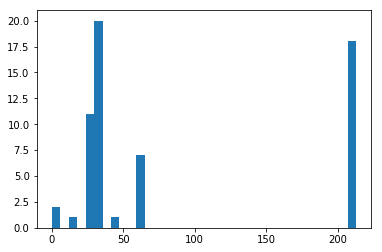

In [36]:
heading_test(460117031)

## Matching process v2

V1: UpdateOne({ '\_id': point['\_id'] }, {'$set': {'matching_road': road['_id']}})

V2: UpdateOne({ '\_id': point['_id'] }, { '$set': { 'matching_road': road['_id'], 'heading_road': heading} })

In [34]:
from affect_road_to_point_para import Affect_road_to_point

In [35]:
db_name, collection_name, db_osm_name, roads_name = "congestion", "coyote2", "osm", "roads"
affect = Affect_road_to_point( db_name, collection_name, db_osm_name, roads_name, 10)

In [36]:
%%time
affect.affect_para(80)

Worker 2 done: 242747 points modified42747
Worker 0 done: 242747 points modified
Worker 26 done: 242747 points modified
Worker 4 done: 242747 points modified
Worker 5 done: 242747 points modified
Worker 11 done: 242747 points modified
Worker 6 done: 242747 points modified
Worker 24 done: 242747 points modified
Worker 1 done: 242747 points modified
Worker 7 done: 242747 points modified
Worker 3 done: 242747 points modified
Worker 14 done: 242747 points modified
Worker 8 done: 242747 points modified
Worker 10 done: 242747 points modified
Worker 13 done: 242747 points modified
Worker 15 done: 242747 points modified
Worker 9 done: 242747 points modified
Worker 19 done: 242747 points modified
Worker 16 done: 242747 points modified
Worker 21 done: 242747 points modified
Worker 20 done: 242747 points modified
Worker 18 done: 242747 points modified
Worker 27 done: 242747 points modified
Worker 31 done: 242747 points modified
Worker 28 done: 242747 points modified
Worker 12 done: 242747 points 

## Creating the matrix of speeds

### Basic matrix (no heading, no time)

In [43]:
avg_speed = pd.DataFrame(
    list(data.aggregate(
          [{
            "$group" : {
               "_id" : "$matching_road",
                "avg_speed": {"$avg": "$speed"},
                "count": {"$sum": 1}
            }
          }]
        )
    ))

In [45]:
avg_speed.head()

,_id,avg_speed,count
0,458531417,97.50000,6
1,618763656,29.25000,4
2,618763657,24.46875,32
3,458531418,19.00000,7
4,458531419,22.00000,3


### Improved matrix (no headings, time frame)

In [65]:
def get_speed_matrix(timeframe):
    avg_speed = pd.DataFrame(
        list(data.aggregate(
              [{
                "$group" : {
                    "_id" : {
                        "matching_road": "$matching_road",
                        "time": {
                            "$toDate": {
                                "$subtract": [
                                  { "$toLong": "$time"},
                                  { "$mod": [ { "$toLong": "$time"}, 1000 * 60 * timeframe] }
                                ]
                              }
                        }
                    },
                    "avg_speed": {"$avg": "$speed"},
                    "count": {"$sum": 1},
                    "matching_road": {"$first": "$matching_road"},
                }
              }]
            )
        ))
    avg_speed['time'] = avg_speed2['_id'].apply(lambda x: x['time'])
    return avg_speed

In [66]:
avg_speed2 = get_speed_matrix(15)

In [67]:
avg_speed2.head(10)

,_id,avg_speed,count,matching_road,time
0,"{'matching_road': 358549763, 'time': 2018-10-1...",102.0,1,358549763,2018-10-14 11:15:00
1,"{'matching_road': 358549763, 'time': 2018-10-1...",105.0,1,358549763,2018-10-14 11:00:00
2,"{'matching_road': 25668256, 'time': 2018-10-12...",126.0,1,25668256,2018-10-12 20:45:00
3,"{'matching_road': 25620793, 'time': 2018-10-13...",0.0,8,25620793,2018-10-13 20:00:00
4,"{'matching_road': 25620793, 'time': 2018-10-13...",0.0,6,25620793,2018-10-13 00:30:00
5,"{'matching_road': 25620793, 'time': 2018-10-13...",0.0,4,25620793,2018-10-13 00:15:00
6,"{'matching_road': 25620793, 'time': 2018-10-13...",0.0,9,25620793,2018-10-13 20:15:00
7,"{'matching_road': 25620793, 'time': 2018-10-13...",0.0,12,25620793,2018-10-13 19:45:00
8,"{'matching_road': 25620793, 'time': 2018-10-13...",31.0,1,25620793,2018-10-13 14:30:00
9,"{'matching_road': 25620793, 'time': 2018-10-12...",66.0,1,25620793,2018-10-12 13:15:00


In [68]:
speeds = avg_speed2.pivot(index='matching_road', columns='time', values='avg_speed')

In [69]:
speeds.head(10)

time,2018-10-12 08:45:00,2018-10-12 09:00:00,2018-10-12 09:15:00,2018-10-12 09:30:00,2018-10-12 09:45:00,2018-10-12 10:00:00,2018-10-12 10:15:00,2018-10-12 10:30:00,2018-10-12 10:45:00,2018-10-12 11:00:00,...,2018-10-14 14:45:00,2018-10-14 15:00:00,2018-10-14 15:15:00,2018-10-14 15:30:00,2018-10-14 15:45:00,2018-10-14 16:00:00,2018-10-14 16:15:00,2018-10-14 16:30:00,2018-10-14 16:45:00,2018-10-14 17:00:00
matching_road,,,,,,,,,,,,,,,,,,,,,
4303414,92.000000,91.50,80.000000,86.666667,82.000000,88.750000,92.714286,75.333333,80.750000,82.666667,...,79.0,86.0,86.75,76.00,94.333333,92.50,84.0,87.666667,95.5,88.666667
4384550,49.800000,60.25,64.833333,58.142857,68.272727,63.000000,64.400000,57.000000,57.333333,48.333333,...,70.0,62.0,64.00,82.75,65.500000,62.75,69.5,60.142857,68.0,70.000000
4384636,26.000000,64.00,81.000000,82.000000,NaN,102.666667,73.500000,74.000000,106.000000,85.800000,...,NaN,79.0,NaN,111.00,NaN,92.50,103.5,NaN,84.0,93.000000
4384638,NaN,65.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4384639,19.666667,51.00,NaN,NaN,49.000000,14.000000,NaN,6.000000,NaN,62.000000,...,75.0,NaN,0.00,NaN,NaN,65.00,NaN,NaN,NaN,NaN
4439007,27.500000,83.00,NaN,NaN,87.333333,79.000000,84.000000,52.000000,73.500000,81.000000,...,NaN,NaN,NaN,NaN,90.000000,NaN,89.0,90.000000,88.0,NaN
4674585,35.500000,NaN,NaN,NaN,35.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,41.00,NaN,47.000000,NaN,NaN,20.000000,NaN,NaN
4674603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4674604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
speeds.describe()

time,2018-10-12 08:45:00,2018-10-12 09:00:00,2018-10-12 09:15:00,2018-10-12 09:30:00,2018-10-12 09:45:00,2018-10-12 10:00:00,2018-10-12 10:15:00,2018-10-12 10:30:00,2018-10-12 10:45:00,2018-10-12 11:00:00,...,2018-10-14 14:45:00,2018-10-14 15:00:00,2018-10-14 15:15:00,2018-10-14 15:30:00,2018-10-14 15:45:00,2018-10-14 16:00:00,2018-10-14 16:15:00,2018-10-14 16:30:00,2018-10-14 16:45:00,2018-10-14 17:00:00
count,1674.000000,1509.000000,1358.000000,1215.000000,1240.000000,1218.000000,1273.000000,1254.000000,1305.000000,1212.000000,...,606.000000,668.000000,719.000000,672.000000,703.000000,757.000000,798.000000,856.000000,844.000000,668.000000
mean,26.514440,29.952000,31.385771,32.777640,32.264883,32.896608,31.221025,31.589787,31.250773,32.190923,...,40.176839,39.356230,40.777479,39.012098,41.269142,38.146188,39.607721,38.737889,38.443690,38.206444
std,24.195001,27.007779,28.162341,28.675326,28.543327,28.188535,28.169934,28.251496,27.314526,29.202059,...,31.274459,32.154550,31.545001,31.881507,32.139413,31.205869,31.646047,29.801011,30.209574,30.183631
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,7.666667,7.000000,8.000000,8.000000,9.233333,7.000000,6.500000,8.333333,6.500000,...,15.000000,12.333333,17.000000,13.000000,16.000000,12.000000,15.125000,15.000000,15.000000,14.000000
50%,22.000000,25.000000,26.333333,28.000000,27.000000,28.500000,26.000000,26.750000,27.000000,26.000000,...,35.000000,34.833333,35.000000,34.000000,35.333333,33.000000,33.875000,35.000000,33.750000,34.000000
75%,38.000000,42.545455,45.458333,47.000000,47.000000,48.000000,46.000000,46.900000,44.000000,46.750000,...,59.000000,59.000000,62.250000,55.000000,63.200000,57.000000,59.000000,55.000000,56.000000,54.000000
max,130.000000,130.000000,130.000000,129.000000,130.000000,130.000000,130.000000,125.000000,130.000000,130.000000,...,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,119.500000,130.000000


In [70]:
print_road(4303414)

<font color="red">** Faire attention avec les comportements aberrants !! **</font>

Exemple: sur la route 25620793, l'utilisateur C900F53BC56481BAC6755EF9FC1BB565, est tout le temps à speed = 0 au point [48.11,-1.66]

In [64]:
print_road(25620793)

In [62]:
folium_map = folium.Map(location=[48.11,-1.66],
                         zoom_start=13,
                         tiles="OpenStreetMap")
folium.Marker([48.05527, -1.61684], popup='plop').add_to(folium_map)

folium_map

### Matrix with directions

Use the function to know road heading during the "road matching" => heading : 0/1 instead of [0, 360]

In [4]:
cur = roads.find(   
    {
        "loc": {
            "$geoIntersects": {
                "$geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [[-1.5460, 48.1656],
                         [-1.5460, 48.0632],
                         [-1.7626, 48.0632],
                         [-1.7626,48.1656],
                         [-1.5460, 48.1656]]
                    ]
                }
            }
        },    
        "tag.k": "highway",    
        "tag.v": {
          "$in": [
            "motorway", 
            "trunk", 
            "primary",
            "secondary", 
            "tertiary", 
            "motorway_link", 
            "trunk_link", 
            "primary_link",
            "secondary_link", 
            "tertiary_link"
          ]
        }
    },
    {'_id': 1}
)

main_roads = [r['_id'] for r in cur]
main_roads

[35478524,
 376692521,
 226057036,
 302201368,
 317106155,
 543380718,
 220667241,
 220667242,
 220665949,
 220665936,
 220665937,
 220665940,
 220665942,
 220665945,
 220665946,
 220665947,
 220665951,
 35478525,
 24956576,
 311821852,
 25205548,
 376706291,
 326907911,
 311931228,
 311931226,
 220492650,
 311931215,
 311931198,
 25205542,
 5077942,
 16205794,
 311931210,
 311931170,
 311931174,
 571456698,
 571456703,
 605660372,
 5077943,
 5829390,
 311931212,
 311931217,
 623168311,
 623168312,
 311931189,
 40979485,
 260204488,
 377899117,
 571456701,
 427428259,
 23544978,
 23544984,
 23544991,
 23544992,
 454670594,
 454670595,
 23544985,
 23544986,
 23544987,
 24849601,
 23754416,
 25981782,
 28155152,
 48559604,
 219701049,
 28155148,
 427088812,
 469948406,
 601985147,
 24048615,
 427088813,
 469803705,
 469803706,
 618763800,
 400967412,
 427088810,
 26526476,
 23772807,
 439004724,
 537902448,
 427088811,
 466973192,
 20465236,
 20465235,
 39351951,
 269609440,
 4926492,
 3

In [17]:
def get_speed_matrix(timeframe):
    avg_speed = pd.DataFrame(
        list(data.aggregate(
              [
                {"$match": {"matching_road" :{"$in": roads_ids }}},
                {
                "$group" : {
                    "_id" : {
                        "matching_road": "$matching_road",
                        "heading": "$heading_road",
                        "time": {
                            "$toDate": {
                                "$subtract": [
                                  { "$toLong": "$time"},
                                  { "$mod": [ { "$toLong": "$time"}, 1000 * 60 * timeframe] }
                                ]
                              }
                        }
                    },
                    "avg_speed": {"$avg": "$speed"},
                    "count": {"$sum": 1},
                    "matching_road": {"$first": {"$concat": [{"$toString":"$matching_road"}, "_", {"$toString": "$heading_road"}]}},
                }
              }]
            )
        ))
    avg_speed['time'] = avg_speed['_id'].apply(lambda x: x['time'])
    return avg_speed

In [26]:
avg_speed = get_speed_matrix_headings(15)
avg_speed.head()

""


In [7]:
avg_speed = get_speed_matrix_headings(15)
avg_speed.describe()

,avg_speed,count
count,133627.000000,133627.000000
mean,38.208975,2.590068
std,29.385924,4.517970
min,0.000000,1.000000
25%,16.000000,1.000000
50%,33.000000,1.000000
75%,53.333333,2.000000
max,130.000000,224.000000


In [19]:
speeds = avg_speed.pivot(index='matching_road', columns='time', values='avg_speed')

In [20]:
speeds.head(10)

time,2018-10-12 08:45:00,2018-10-12 09:00:00,2018-10-12 09:15:00,2018-10-12 09:30:00,2018-10-12 09:45:00,2018-10-12 10:00:00,2018-10-12 10:15:00,2018-10-12 10:30:00,2018-10-12 10:45:00,2018-10-12 11:00:00,...,2018-10-14 14:45:00,2018-10-14 15:00:00,2018-10-14 15:15:00,2018-10-14 15:30:00,2018-10-14 15:45:00,2018-10-14 16:00:00,2018-10-14 16:15:00,2018-10-14 16:30:00,2018-10-14 16:45:00,2018-10-14 17:00:00
matching_road,,,,,,,,,,,,,,,,,,,,,
100319558_0,11.000000,NaN,NaN,25.0,NaN,NaN,0.0,NaN,NaN,0.0,...,11.0,8.5,NaN,NaN,NaN,NaN,NaN,NaN,37.0,0.0
100319558_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN
100322963_0,45.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100322963_1,9.166667,NaN,23.666667,54.0,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100322964_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100322964_1,NaN,NaN,5.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10057060_0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10057061_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10057061_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Having less Nan

In [5]:
import sys
sys.path.append('../scripts/')
sys.path.append('../source/')

import OsmProcessing
from speed_matrix import SpeedMatrix


In [6]:
importlib.reload(sys.modules['speed_matrix'])
sm = SpeedMatrix("congestion", "coyote2", "osm", "roads")
roads_ids = sm.get_main_roads()
segments=OsmProcessing.getSegments(client['osm'].roads)
len(roads_ids), len(segments)

(4754, 5170)

## Focus on timeframe (17h-20h) 

In [33]:
roads_ids2 = segments.index.values.tolist()
speeds_new = sm.get_speed_matrix(15, roads_ids2, 17, 21)

In [34]:
speeds_new.head()

time,2018-11-13 17:00:00,2018-11-13 17:15:00,2018-11-13 17:30:00,2018-11-13 17:45:00,2018-11-13 18:00:00,2018-11-13 18:15:00,2018-11-13 18:30:00,2018-11-13 18:45:00,2018-11-13 19:00:00,2018-11-13 19:15:00,...,2018-12-11 18:30:00,2018-12-11 18:45:00,2018-12-11 19:00:00,2018-12-11 19:15:00,2018-12-11 19:30:00,2018-12-11 19:45:00,2018-12-11 20:00:00,2018-12-11 20:15:00,2018-12-11 20:30:00,2018-12-11 20:45:00
matching_road,,,,,,,,,,,,,,,,,,,,,
100319558_0,26.0,NaN,NaN,NaN,NaN,NaN,39.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN
100319558_1,33.0,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100319559_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10062754_0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.5
10213325_0,NaN,25.0,NaN,NaN,21.0,0.0,12.0,NaN,6.0,0.0,...,0.0,0.0,8.666667,NaN,NaN,NaN,44.0,NaN,NaN,NaN


In [35]:
percents(speeds_new)

count    6276.000000
mean       79.208928
std        23.002900
min         0.000000
25%        70.703125
50%        88.281250
75%        96.093750
max        99.609375
dtype: float64

In [38]:
per = speeds_new.isnull().sum(axis=1).sort_values(ascending=True) / speeds_new.shape[1] * 100
(per < 25).sum()

302

In [39]:
most_percents20 = list(per[(per < 20)].index.values)
most_percents20 = [r.split('_')[0] for r in most_percents20]

most_percents22 = list(per[(per >= 20) & (per < 22)].index.values)
most_percents22 = [r.split('_')[0] for r in most_percents22]

most_percents25 = list(per[(per >= 22) & (per < 25)].index.values)
most_percents25 = [r.split('_')[0] for r in most_percents25]

most_percents25

['5079151',
 '43134670',
 '291477860',
 '20648062',
 '249736372',
 '5106971',
 '48744696',
 '618763700',
 '360147392',
 '5057562',
 '448920113',
 '265098404',
 '618763779',
 '26149292',
 '124191526',
 '23088201',
 '4384550',
 '362465503',
 '25726626',
 '5057562',
 '615903532',
 '50468721',
 '49424503',
 '625732202',
 '292801341',
 '42872855',
 '4951205',
 '25507986',
 '176015808',
 '362451769',
 '5355038',
 '11027379',
 '23655055',
 '313994131',
 '173399534',
 '27561033',
 '4951215',
 '5057552',
 '205933706',
 '582513720',
 '322116282',
 '5002100',
 '618763761',
 '8877318',
 '51071053',
 '618763466',
 '362451768',
 '27676541',
 '357230902',
 '51138019',
 '5571610',
 '173399535',
 '619125848',
 '28681474',
 '292801259']

### Notes on the speed matrix

#### 17h 20h

routes_1720.html | bleu < 20% | 20% < vert < 22% | 22% < rouge < 25%

----
- count    6260.000000
- mean       75.528737
- std        25.581367
- min         0.000000
- 25%        64.062500
- 50%        85.416667
- 75%        95.312500
- max        99.479167

##### 20%
- routes_1720_20p.html
- 375 roads

##### 22%
- routes_1720_22p.html
- 414 roads

##### 25%
- routes_1720_25p.html
- 458 roads



#### 17h 21h

routes_1721.html | bleu < 20% | 20% < vert < 22% | 22% < rouge < 25%

----
- count    6276.000000
- mean       79.208928
- std        23.002900
- min         0.000000
- 25%        70.703125
- 50%        88.281250
- 75%        96.093750
- max        99.609375

##### 20%
- routes_1721_20p.html
- 215 roads

##### 22%
- routes_1721_22p.html
- 247 roads

##### 25%
- routes_1721_25p.html
- 302 roads


In [40]:
folium_map = folium.Map(location=[48.14301,-1.69537],
                        zoom_start=13,
                        tiles="OpenStreetMap")

coords20 = [roads.find({'_id': int(i)})[0]['loc']['coordinates'] for i in most_percents20]
coords22 = [roads.find({'_id': int(i)})[0]['loc']['coordinates'] for i in most_percents22]
coords25 = [roads.find({'_id': int(i)})[0]['loc']['coordinates'] for i in most_percents25]


[folium.PolyLine(locations=[[lo[1],lo[0]] for lo in x]).add_to(folium_map) for x in coords20]
[folium.PolyLine(locations=[[lo[1],lo[0]] for lo in x], color='green').add_to(folium_map) for x in coords22]
[folium.PolyLine(locations=[[lo[1],lo[0]] for lo in x], color='red').add_to(folium_map) for x in coords25]
folium_map.save('routes_1721.html')
folium_map